# Allele Specificity Analysis
#### By: Roham Razaghi (rrazagh1@jhu.edu), Timothy Gilpatrick (tgilpat@gmail.com)



##### Below are the bash commands to generate HapCUT2 and annotated vcf files:
$~/HapCUT2/build/extractHAIRS --nf 1 --ont 1 --bam NA12878-DirectRNA.pass.dedup.NoU.fastq.hg38.minimap2.sorted.bam --VCF Na128het.vcf --out NA12878het.fullgenome.extractHairs --ref /mithril/Data/NGS/Reference/human38/GRCH38.fa

$java -Xmx12g -jar ~/snpEff/snpEff/snpEff.jar -c ~/snpEff/snpEff/snpEff.config -d -v -canon -no-downstream -no-intergenic -no-upstream GRCh38.86 Na128het.vcf > Na128het.ann.canon.vcf

$ java -jar ~/snpEff/snpEff/SnpSift.jar extractFields -s "," -e "." Na128het.ann.canon.vcf CHROM POS REF ALT "ANN[*].GENE" "ANN[*].EFFECT" "GEN[*].GT" > Na128het.ann.canon.snpsift.vcf

#### Assigning allele specificity to each read:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# EEF2

params = {'legend.fontsize': 20,
          'legend.handlelength': 2,
          'axes.titlesize' : 40,
          'axes.labelsize' : 40,
          'lines.linewidth' : 3,
          'lines.markersize' : 10,
          'xtick.labelsize' : 25,
          'ytick.labelsize' : 25}
plt.rcParams.update(params)

sns.set_style('ticks')
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.rcParams['figure.figsize']=30,10

def block_specificity(block_offset, block_alleles, variant_file):
    """
    This Function assigns specificity to each block.
    for more information about the extractHAIR command output: 
    https://github.com/vibansal/HapCUT2/blob/master/old/FAQ.md
    """
    spec = ''
    genes = []
#     chrom = ''
    num_variants = len(block_alleles)
    
    for i in range(num_variants):
        
        line = variant_file[int(block_offset) + i].split('\t')
        genotype = line[6].split('|')
        if block_alleles[i] == genotype[0]:
            spec += 'P'
        elif block_alleles[i] == genotype[1]:
            spec += 'M'
        chrom = line[0]
        genes.append(line[4].split(','))
        
   
    return chrom,genes,spec

def uniq(seq):
    """
    Output uniq values of a list
    """
    Set = set(seq)
    return list(Set) 


def read_specificity(fragment_line, variant_file):
    """
    Finally assigning specificity to each read
    """
    genes_frag = []
    spec_frag = ''

    fragment = fragment_line.split(' ')
    num_blocks = int(fragment[0])
    for i in range(num_blocks):
        block_offset = fragment[5 + (2*i)]
        block_alleles = fragment[6 + (2*i)]
        chrom,genes,spec = block_specificity(block_offset, block_alleles, variant_file)
        genes_frag.append([y for x in genes for y in x])
        spec_frag += spec
        
    genes_frag = uniq([y for x in genes_frag for y in x])
        
    return chrom,genes_frag,spec_frag
    


if __name__ == '__main__':
    
    with open('Na128het.ann.canon.snpsift.vcf') as g:
        
        variant_file = g.read().splitlines()
    
    fg = open('NA12878het.fullgenome.extractHairs')
    outF = open("test.ase", "w")
    for fragment_line in fg:

        chrom,genes,spec = read_specificity(fragment_line, variant_file)
        p_ratio = spec.count('P')/float(len(spec))
        m_ratio = spec.count('M')/float(len(spec))
        if p_ratio >= 0.75:
            allele_calling = 'P'
        elif m_ratio >= 0.75:
            allele_calling = 'M'
        else:
            allele_calling = '.'
                   
        new_fragment_line = fragment_line[:-2] + ' ' + chrom + ' ' + ",".join([str(x) for x in genes]) + ' ' + str(p_ratio) + ' ' + str(m_ratio) + ' ' + allele_calling 
        print(new_fragment_line, end="\n", file=outF)
        
    outF.close()
    fg.close()

    


/Users/roham/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/roham/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/roham/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


#### Intersect output with FLAIR output to have gene/isoform specificity statistics:

In [3]:
file = "test.ase"
f = open(file)
read_to_specificity = {}
read_to_chrom = {}

for line in f:
    read_id = line.split(' ')[1]
    specificity = line.split(' ')[-1][0]
    chrom = line.split(' ')[-5]
    read_to_specificity[read_id] = specificity
    read_to_chrom[read_id] = chrom
f.close()

In [57]:
file = "./polyA/nvrna.180828.read.isoform.map.txt"
f = open(file)

outF = open("nvrna.isoform.map.ase28.txt", "w")
print("#Read_ID\tIsoform_ID\tAllele_specificity\tChr", end="\n", file=outF)
genes_stats = {}
isoforms_stats = {}
gene_to_reads = {}
isoform_to_reads = {}
gene_to_chrom = {}
for line in f:
    line_arr = line.strip().split('\t')
    read_id = line_arr[0]
    isoform_id = line_arr[1].split('_')[0].split('.')[0]
    try:
        
        gene_id = line_arr[1].split('_')[1].split('.')[0]
    except IndexError:
        continue 
    if read_id in read_to_specificity.keys():
        gene_to_reads.setdefault(gene_id,[]).append(read_id)
        isoform_to_reads.setdefault(isoform_id,[]).append(read_id)
        new_line = line.strip() + '\t' +  read_to_specificity[read_id] + '\t' + read_to_chrom[read_id]
        print(new_line, end="\n", file=outF)
        
        genes_stats.setdefault(gene_id,[]).append(read_to_specificity[read_id])
        isoforms_stats.setdefault(isoform_id+'_'+gene_id,[]).append(read_to_specificity[read_id])
        gene_to_chrom[gene_id] = read_to_chrom[read_id]
        
outF2 = open("nvrna.gene.stats28.txt", "w")
print("Gene_ID\treads\tMaternal\tPaternal\tChr", end="\n", file=outF2)
[print(str(k+'\t'+ str(len(v))+'\t' + str(float(v.count('M'))/len(v))+ '\t' + str(float(v.count('P'))/len(v))+ '\t'+ gene_to_chrom[k]), end="\n", file=outF2) for k,v in genes_stats.items()]
outF3 = open("nvrna.isoform.stats28.txt","w")
print("isoform_ID\tGene_ID\treads\tMaternal\tPaternal", end="\n", file=outF3)
[print(str(k.split('_')[0]+'\t'+k.split('_')[1]+'\t'+ str(len(v))+'\t' + str(float(v.count('M'))/len(v))+ '\t' + str(float(v.count('P'))/len(v))), end="\n", file=outF3) for k,v in isoforms_stats.items()]

outF.close()
outF2.close()
outF3.close()
f.close()

#### Now we can visualize data:

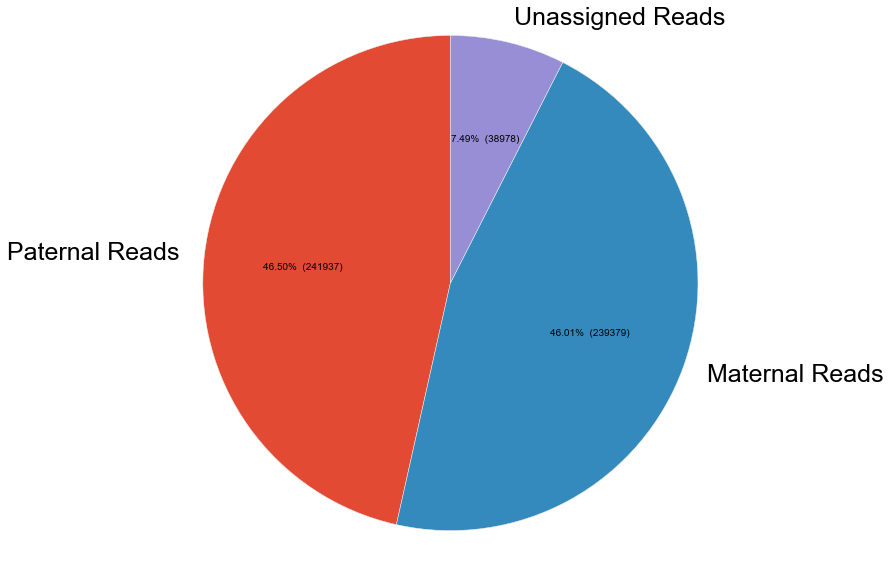

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
df = pd.read_csv('nvrna.isoform.map.ase28.txt',sep='\t')
reads_assignment = df['Allele_specificity'].value_counts().tolist()

label = ['Paternal Reads', 'Maternal Reads', 'Unassigned Reads']
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

fig1, ax1 = plt.subplots()
fig1.set_size_inches(8,8)
patches, texts, autotexts = ax1.pie(reads_assignment, labels=label, autopct=make_autopct(reads_assignment), startangle=90, )
for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('black')
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()

In [72]:
df = pd.read_csv('nvrna.gene.stats28.txt',sep='\t')
df = df[(df.reads >= 5)]
# paternal_x = df[(df.reads >= 5) & (df.Chr == "chrX") & (df.Paternal >= 0.9)]
# maternal_x = df[(df.reads >= 5) & (df.Chr == "chrX") & (df.Maternal >= 0.9)]

def f(row):
    if row['Maternal'] >= 0.8:
        val = 'Maternal'
    elif row['Paternal'] >= 0.8:
        val = 'Paternal'
    else:
        val = 'Unassigned'
    return val
df['ASE'] = df.apply(f, axis=1)
df.head()

,Gene_ID,reads,Maternal,Paternal,Chr,ASE
0,ENSG00000106638,137,0.394161,0.540146,chr7,Unassigned
1,ENSG00000145901,2267,0.427878,0.477283,chr5,Unassigned
2,ENSG00000166501,446,0.526906,0.448430,chr16,Unassigned
3,ENSG00000136068,59,0.457627,0.423729,chr3,Unassigned
4,ENSG00000105193,15148,0.402099,0.573805,chr19,Unassigned


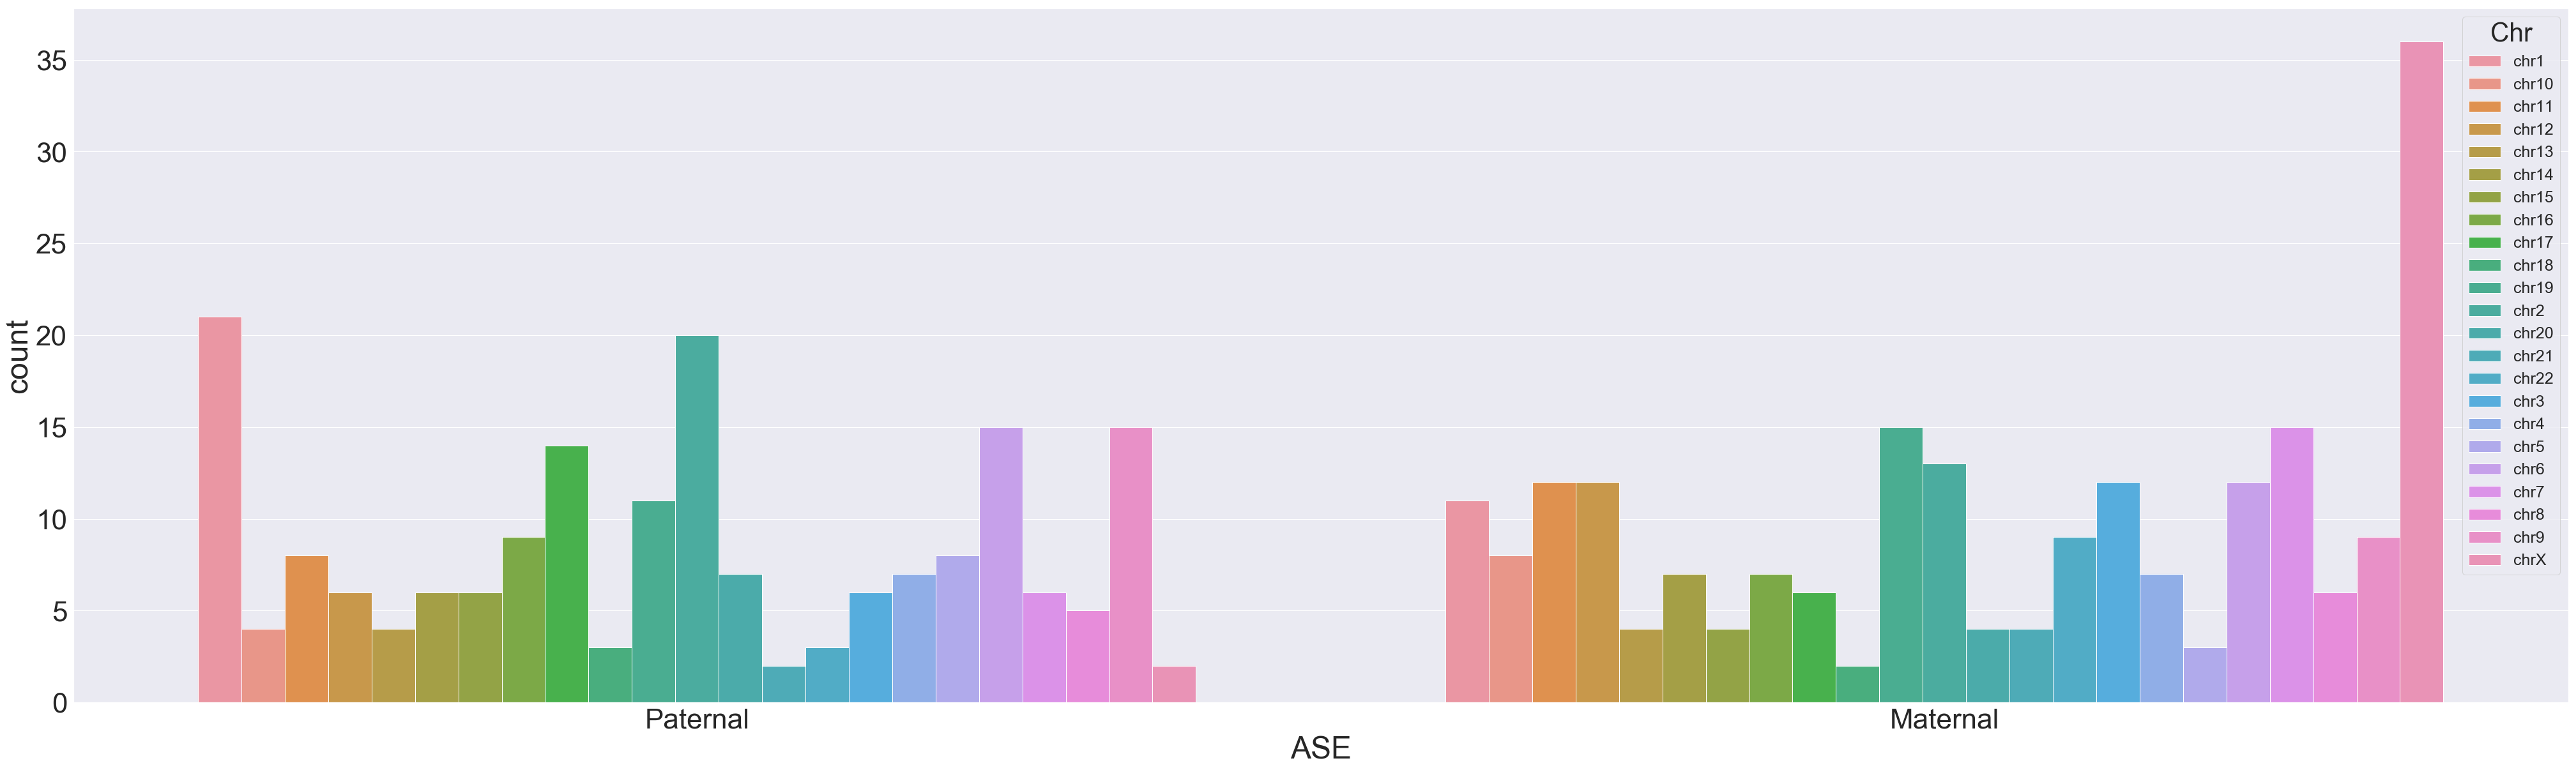

In [73]:
plt.style.use('ggplot')
# titanic
plt.rcParams['figure.figsize']=70,20
sns.set(font_scale=4)
plt.rcParams['legend.fontsize']= 25
ax = sns.countplot(x="ASE", hue="Chr", data=df[(df.ASE != 'Unassigned')].sort_values('Chr'))

#### Let's take a closer look at chromosome X since it has the least unassigned ASE genes and X-inactivation is observed:

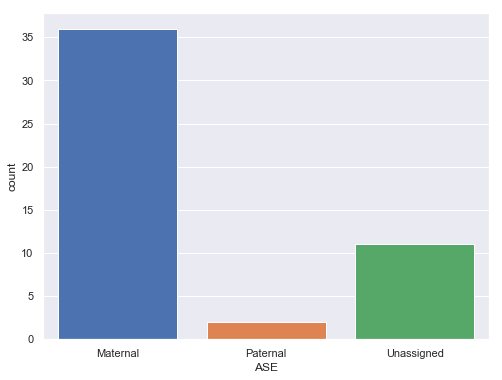

In [74]:
df1 = df[(df.Chr == 'chrX')]
plt.rcParams['figure.figsize']=8,6
sns.set(font_scale=1)
plt.rcParams['legend.fontsize']= 15
ax = sns.countplot(x="ASE", data=df1,saturation=1)

#### Now let's see if we can separate the allele specific reads and visualize in IGV:

In [9]:
df.sort_values('reads', ascending=False).head()

,Gene_ID,reads,Maternal,Paternal,Chr,ASE
5,ENSG00000075624,66983,0.479614,0.487273,chr7,Unassigned
13,ENSG00000111640,40374,0.491430,0.384530,chr12,Unassigned
4,ENSG00000105193,15148,0.402099,0.573805,chr19,Unassigned
12,ENSG00000134333,11201,0.492545,0.413981,chr11,Unassigned
111,ENSG00000136167,7317,0.417384,0.504852,chr13,Unassigned


AS an example we choose ACTB (ENSG00000075624) with the highest number of reads

In [12]:
import pysam
bamfile = pysam.AlignmentFile('NA12878-DirectRNA.pass.dedup.NoU.fastq.hg38.minimap2.sorted.bam', 'rb')
name_indexed = pysam.IndexedReads(bamfile)
name_indexed.build()
header = bamfile.header.copy()
# this is probably not very efficient as it uses up a lot of memory but it'll do the job for now

In [10]:
def ase_reads(reads, read_to_specificity):
    paternal_reads = []
    maternal_reads = []
    for read in reads:
        if read_to_specificity[read] == 'M':
            maternal_reads.append(read)
        if read_to_specificity[read] == 'P':
            paternal_reads.append(read)
    return paternal_reads,maternal_reads

actb_paternal,actb_maternal = ase_reads(gene_to_reads['ENSG00000075624'], read_to_specificity)

out_p = pysam.Samfile('ACTB_paternal.bam', 'wb', header=header)
out_m = pysam.Samfile('ACTB_maternal.bam', 'wb', header=header)
for name in actb_paternal:
    iterator = name_indexed.find(name)
    for x in iterator:
        out_p.write(x)
out_p.close()
for name in actb_maternal:
    iterator = name_indexed.find(name)
    for x in iterator:
        out_m.write(x)
out_m.close()

Let's visualize the two bam files in IGV and note the two alleles different than the referrence in the maternal file

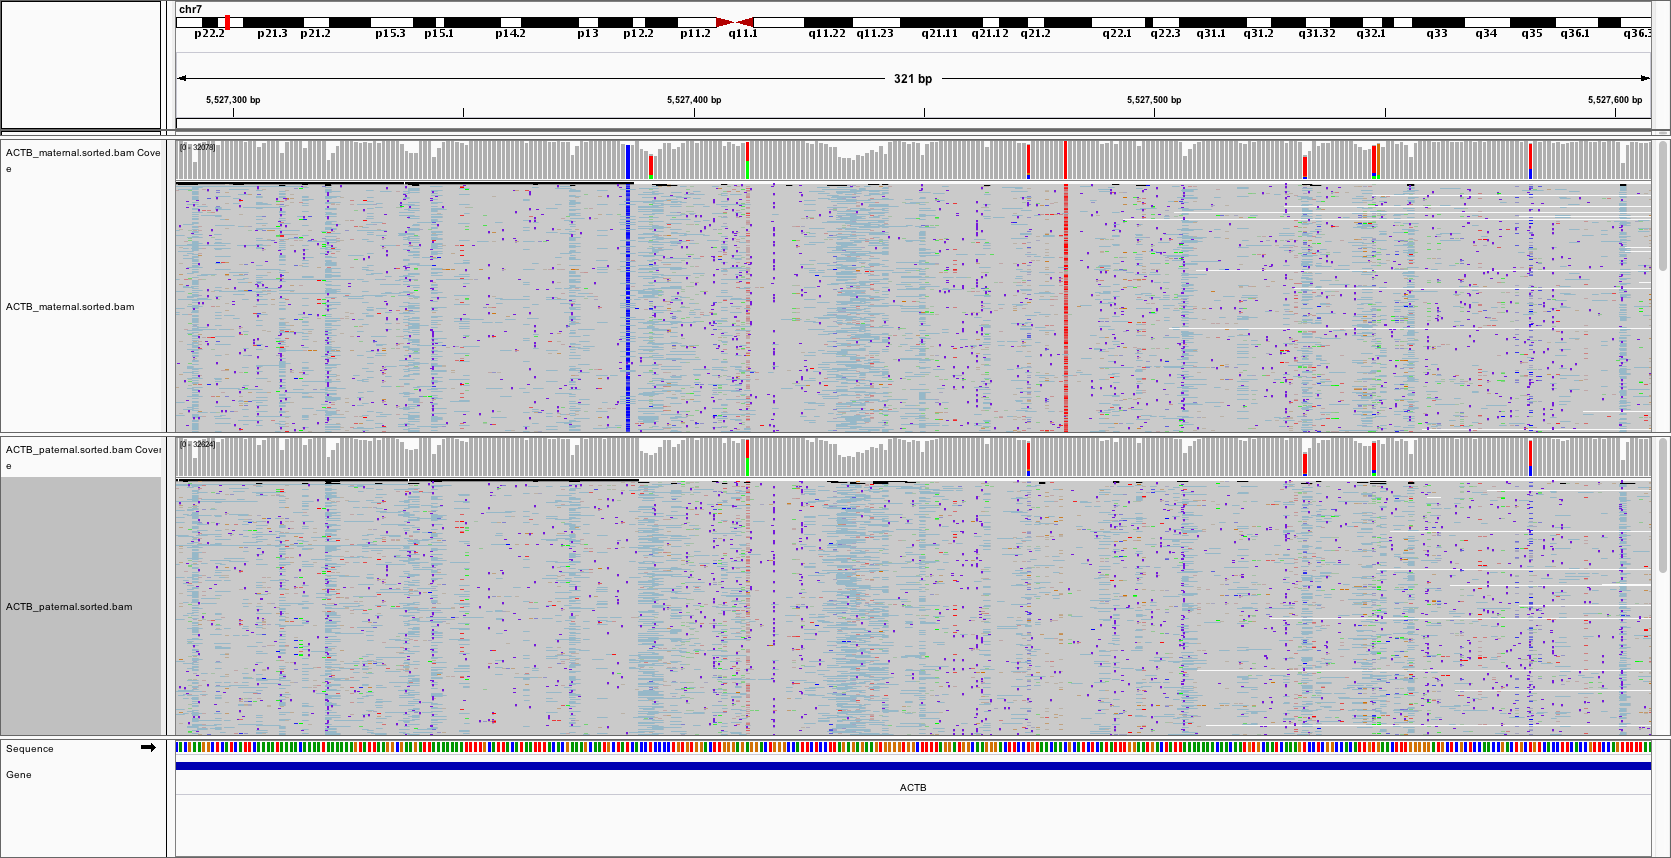

In [108]:
from IPython.display import Image
Image(filename='actb.png') 

#### Let's see if we can find any genes with specific isoform alle expression:

In [75]:
genes = list(gene_to_reads.keys())
df = pd.read_csv('nvrna.isoform.stats28.txt',sep='\t')
df['ASE'] = df.apply(f, axis=1)
df = df[(df.reads >= 5)]
df.head()

In [91]:
isoform_ase = []
for gene in genes:
    if len(df[(df.Gene_ID == gene) & (df.ASE == 'Paternal')]) >= 1 and len(df[(df.Gene_ID == gene) & (df.ASE == 'Maternal')]) >=1:
        isoform_ase.append(gene)
#         print('Gene ' + gene + ' has isoform specific expression')
isoform_ase_df = df[(df.Gene_ID.isin(isoform_ase))&(df.ASE != 'Unassigned')].sort_values(['reads','Gene_ID'],ascending=False).reset_index(drop=True)

In [95]:
isoform_ase_df

,isoform_ID,Gene_ID,reads,Maternal,Paternal,ASE
0,ENST00000370751,ENSG00000137959,221,0.814480,0.113122,Maternal
1,ENST00000261623,ENSG00000051523,180,0.038889,0.900000,Paternal
2,ENST00000303887,ENSG00000166508,177,0.994350,0.000000,Maternal
3,ENST00000295809,ENSG00000163565,150,0.880000,0.026667,Maternal
4,ENST00000263642,ENSG00000115267,144,0.131944,0.840278,Paternal
5,d7debd96-8a4a-46a7-8a9f-314847da89ac,ENSG00000115267,131,0.801527,0.190840,Maternal
6,a8978c33-3504-48a9-89ff-58fe5bc85cd3,ENSG00000235419,41,0.804878,0.195122,Maternal
7,ENST00000537496,ENSG00000139428,41,0.024390,0.951220,Paternal
8,da5c773b-d5f4-4279-83f7-c77413d72d9f,ENSG00000197256,40,0.800000,0.100000,Maternal
9,1b82000a-e5d3-4cf6-a355-eed256601a0c,ENSG00000137959,29,0.862069,0.068966,Maternal


#### let's go ahead and like above visualize the ENSG00000137959 (IFIH1)'s maternal/paternal isoforms in IGV since it has the most coverage for both mathernal and paternal isoforms:

In [96]:
isoform_ase_df[(isoform_ase_df.Gene_ID == 'ENSG00000115267')]

,isoform_ID,Gene_ID,reads,Maternal,Paternal,ASE
4,ENST00000263642,ENSG00000115267,144,0.131944,0.840278,Paternal
5,d7debd96-8a4a-46a7-8a9f-314847da89ac,ENSG00000115267,131,0.801527,0.190840,Maternal


In [101]:
out_p = pysam.Samfile('IFIH1_ENST00000263642.bam', 'wb', header=header)
out_m = pysam.Samfile('IFIH1_novel.bam', 'wb', header=header)
for name in list(isoform_to_reads['d7debd96-8a4a-46a7-8a9f-314847da89ac']):
    iterator = name_indexed.find(name)
    for x in iterator:
        out_m.write(x)
out_m.close()
for name in list(isoform_to_reads['ENST00000263642']):
    iterator = name_indexed.find(name)
    for x in iterator:
        out_p.write(x)
out_p.close()

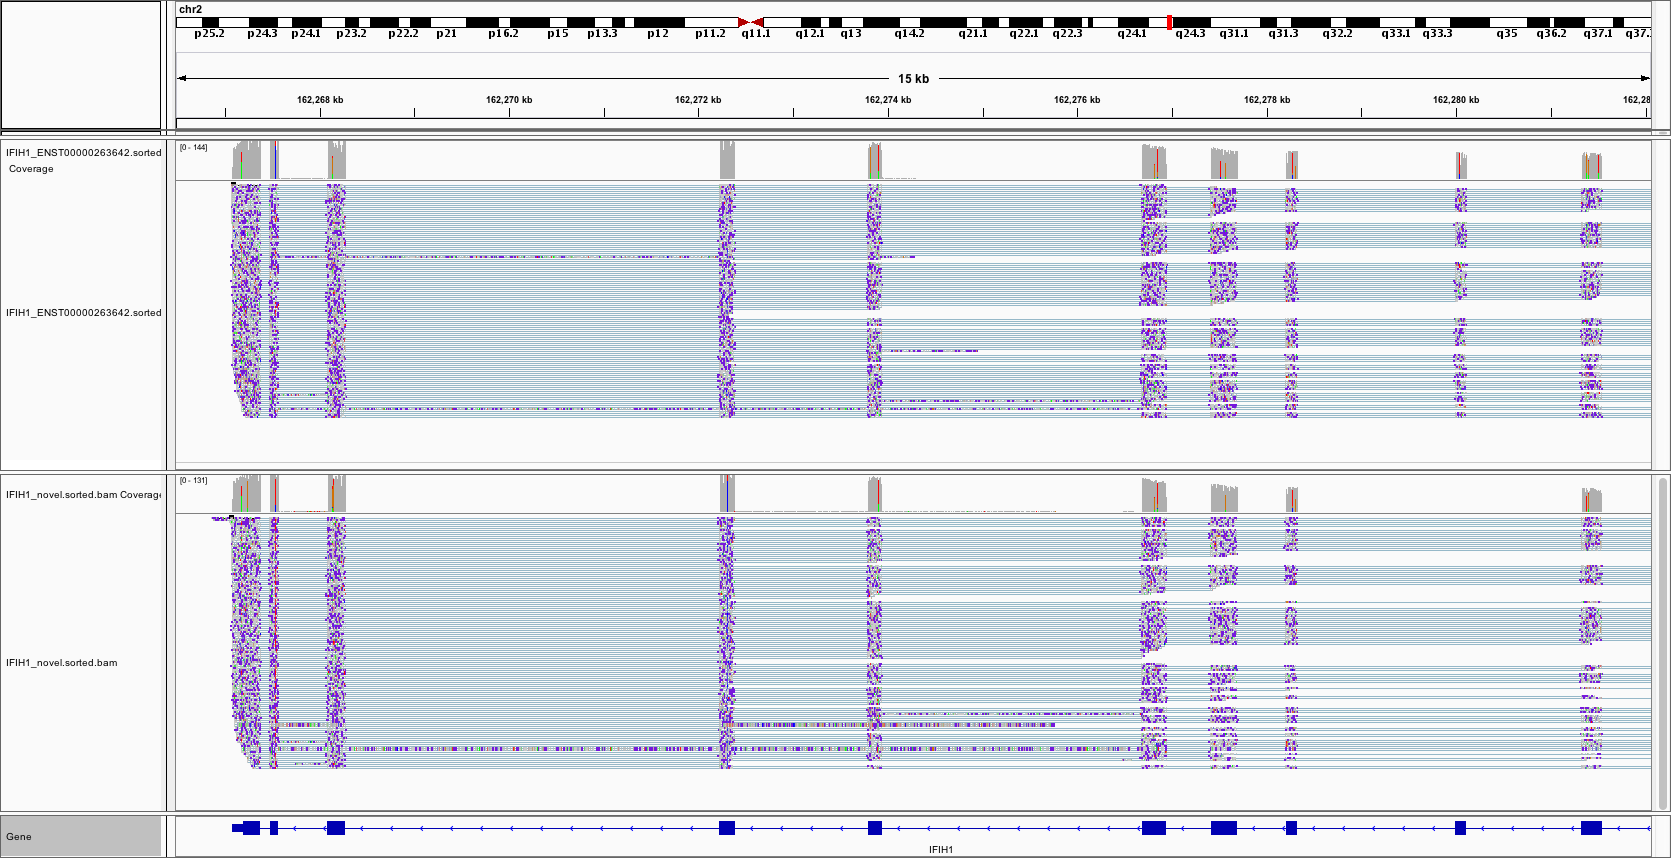

In [109]:
Image(filename='IFIH1.png') 

#### From above we can see that the novel isoform identified does not include an exon, now let's zoom in to find allele specificity:

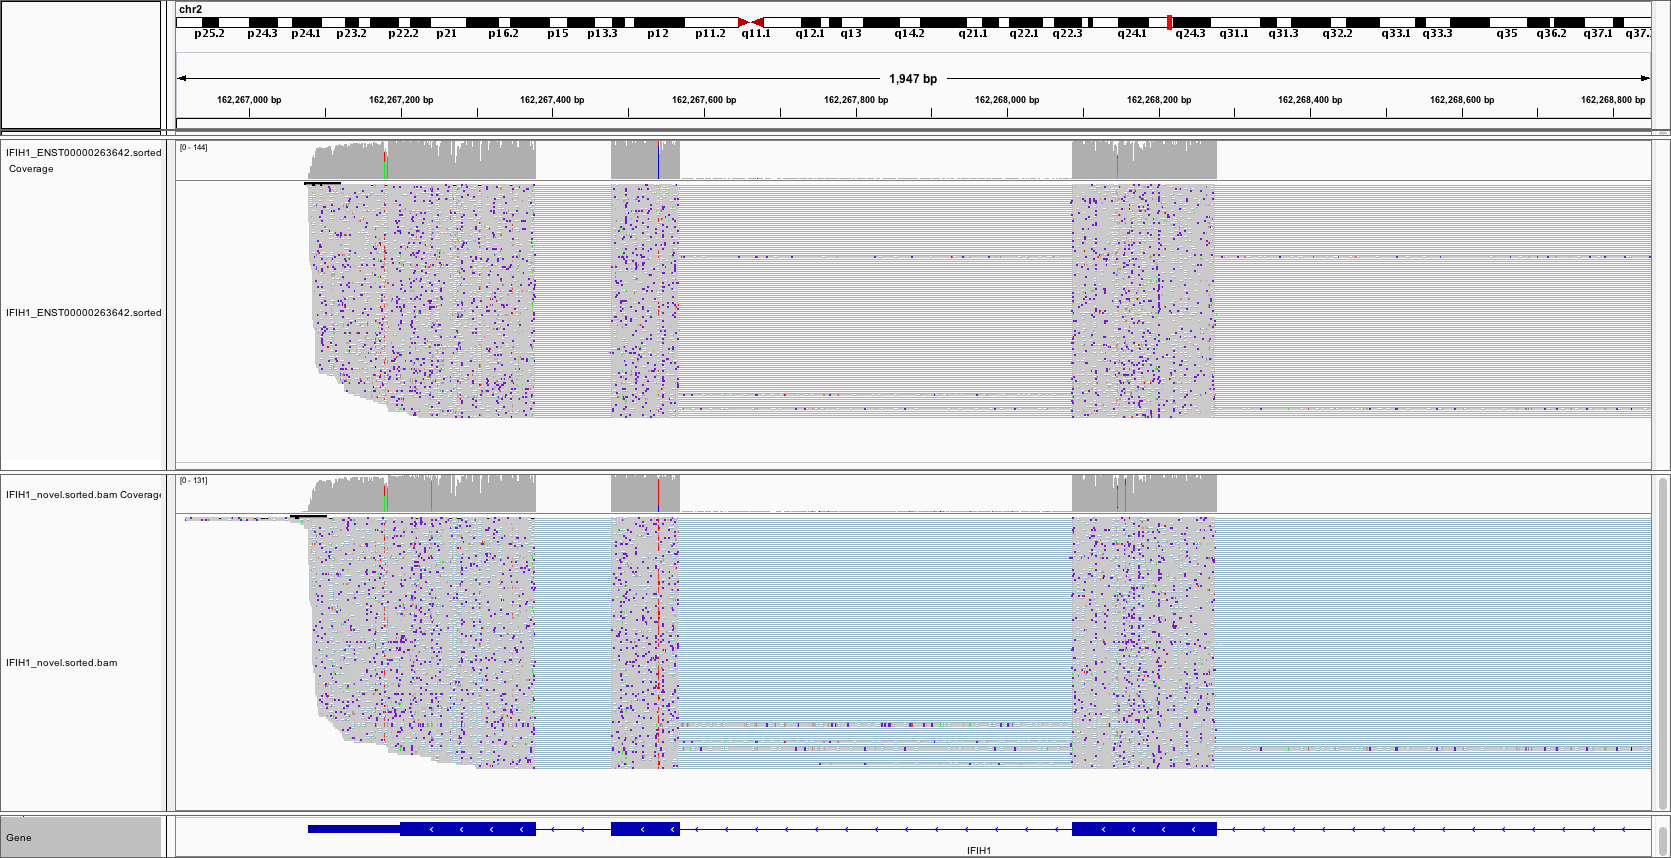

In [110]:
Image(filename='IFIH2.png') 

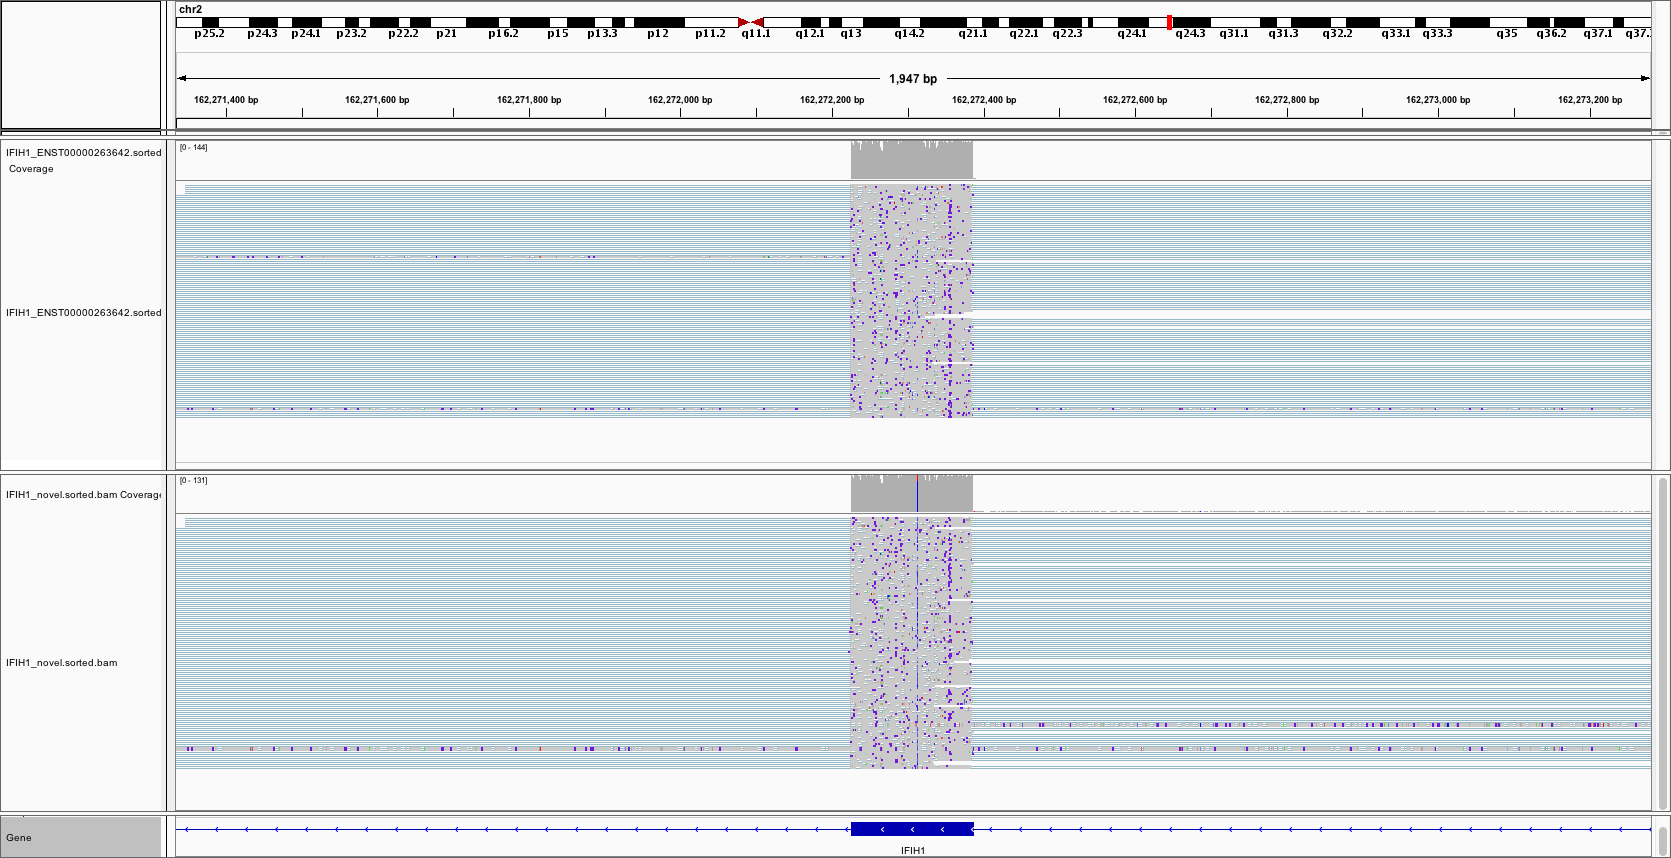

In [111]:
Image(filename='IFIH3.png') 

#### Note that these alleles are about 3kb apart, something that previously was not detectable with conventional short reads